### <center> Measuring the benefits of credit risk model use</center>
<center> We are using Jupyter Notebooks and Matplotlib to render our data </center>

In [1]:
%%capture
!pip install -r ./requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rc, rcParams, font_manager

font_manager.fontManager.addfont('./fonts/ClearSans-Thin.ttf')

plt.rcParams['font.family'] = 'Clear Sans Thin'
plt.rcParams['figure.figsize'] = 8, 6
pd.set_option('display.max_columns', None)

font = {'family': 'Clear Sans Thin',
        'weight': 'bold',
        'size': 16}
rc('font', **font)

### <center> Data </center>
[Lending Club Loans](https://github.com/wampeh1/Ecog314_Spring2017/blob/master/Lecture5/lending_club_loans.csv)

In [4]:
path_to_data = f'data/'

In [5]:
test_dataset = pd.read_csv(f"{path_to_data}/lending_club_loans.csv", header=1, low_memory=False, index_col=False)
test_data = test_dataset[~test_dataset['delinq_2yrs'].isna()].copy()

In [6]:
# creating the target variable
test_data['in_default'] = np.where(
    test_data['loan_status'].isin(['Charged Off', 
                                   'Does not meet the credit policy. Status:Charged Off']), 1, 0)

In [7]:
cols = ['in_default', 'last_pymnt_amnt', 'profit', 'loss']

In [8]:
# print(test_data.columns.to_list())
test_data['ir'] = test_data.int_rate.str.strip('%').astype(float)/100
test_data['profit'] = test_data.loan_amnt * test_data.ir
test_data['loss'] = test_data.loan_amnt * test_data.in_default.mean() / (1 + test_data.in_default.mean())

In [109]:
data = test_data[cols][~test_data[cols].isna()].copy() # removing missing observations

In [137]:
avg_profit, avg_loss = data['profit'].mean(), data['loss'].mean()
print(f"Average profit: {avg_profit:,.0f}\n" 
      f"Average loss: {avg_loss:,.0f}")

Average profit: 1,430
Average loss: 1,454


### <center> Pre-processing </center>

In [111]:
dictionary_nn = {'Variable': []}

# loop through each variable and count missing values
for col in test_data.columns:
    missing_values = test_data[col].isna().sum()
    if missing_values == 0:
        dictionary_nn['Variable'].append(col)
        
values_to_remove = ['id', 'member_id', 'profit', 
                    'loss', 'ir', 'in_default',
                    'zip_code', 'url', 'loan_status',
                    'term', 'int_rate', 'sub_grade', 
                    'initial_list_status',
                    'verification_status', 'issue_d', 'pymnt_plan',
                    'purpose','addr_state','earliest_cr_line','total_rec_prncp',
                    'total_rec_late_fee','recoveries',
                    'collection_recovery_fee', 'total_rec_int','policy_code',
                    'acc_now_delinq', 'delinq_amnt',
                    'funded_amnt', 'funded_amnt_inv', 
                    'loan_amnt', 'delinq_2yrs',
                    'out_prncp_inv', 'total_pymnt']

for value in values_to_remove:
    dictionary_nn['Variable'].remove(value)

### <center> Importances </center>

In [112]:
features = dictionary_nn['Variable']

In [113]:
train_feats = test_data[features].reset_index(drop=True).copy()
test_feats = test_data[features].reset_index(drop=True).copy()

In [114]:
train_feats[0:1]

,installment,grade,home_ownership,annual_inc,dti,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,total_acc,out_prncp,total_pymnt_inv,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,application_type
0,162.87,B,RENT,24000.0,27.65,735.0,739.0,1.0,3.0,0.0,13648.0,9.0,0.0,5833.84,171.62,744.0,740.0,INDIVIDUAL


In [115]:
# target variable
y = test_data.in_default.reset_index(drop=True).to_numpy()
y = pd.DataFrame(np.reshape(y.ravel(), (-1, 1)), columns=['in_default'])

# features
X = test_data[features].reset_index(drop=True).copy()
print(X.shape, y.shape)

ix_train, ix_test = train_test_split(X.index, stratify=y, random_state=24)

(42506, 18) (42506, 1)


In [116]:
# specify categorical features
cat = ['application_type', 'home_ownership', 'grade']

# one-hot encoding categorical features
preprocessor = ColumnTransformer(
    transformers=[('OneHotEncoder', OneHotEncoder(drop='first', handle_unknown='ignore'), cat)], 
    remainder='passthrough',
    verbose_feature_names_out=False)

# define the pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
         n_estimators=100,
         n_jobs=-1,
         min_samples_leaf=1,
         oob_score=True,
         random_state = 42))
])

In [117]:
# training
clf = pipe.fit(X.loc[ix_train], y.loc[ix_train].values.ravel())

# evaluate the classifier on the full set
score = cross_val_score(
    clf, 
    X.loc[ix_train], 
    y.loc[ix_train].values.ravel(), 
    cv=10, 
    scoring='roc_auc')

preds = clf.predict_proba(X.loc[ix_test])[:,1]

# print performance metrics
print(f"Accuracy: {clf.score(X.loc[ix_test], y.loc[ix_test]):.2%}\n"
      f"AUC: {score.mean():.2%} \n"
      f"Gini - cv: {score.mean()*2-1:.2%}\n"
      f"Gini - test: {roc_auc_score(y.loc[ix_test].to_numpy(), preds)*2-1:.2%}")

Accuracy: 94.54%
AUC: 96.94% 
Gini - cv: 93.89%
Gini - test: 94.95%


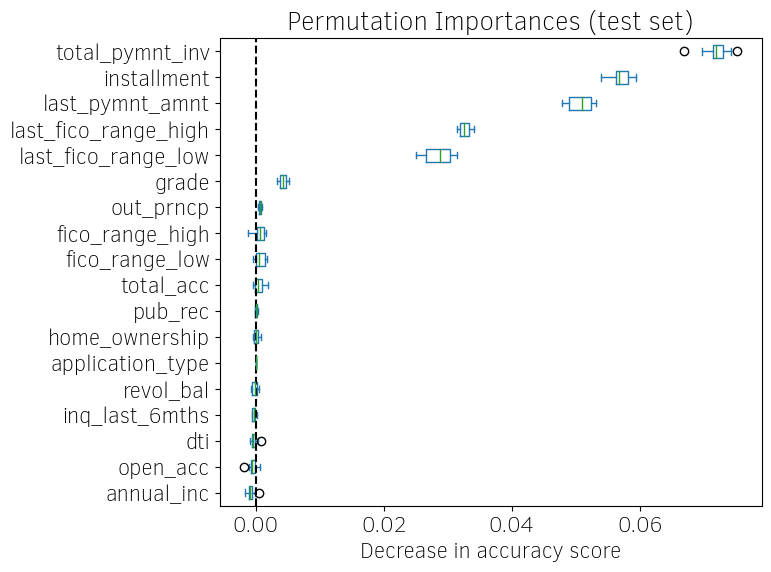

In [118]:
# importances
result = permutation_importance(
    clf, 
    X.loc[ix_test], 
    y.loc[ix_test], 
    n_repeats=10, 
    random_state=42, 
    n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.loc[ix_test].columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

### <center> Stacked logit model </center>
<center> Stack the logits from two models and pass them to another Logistic Regression </center>

In [127]:
internal_feats = importances.iloc[:, -3:].columns.tolist()
print(f"Internal features: {internal_feats}")

external_feats = ['last_fico_range_high','last_fico_range_low']
print(f"External features: {external_feats}")

Internal features: ['last_pymnt_amnt', 'installment', 'total_pymnt_inv']
External features: ['last_fico_range_high', 'last_fico_range_low']


In [128]:
# prepare train and test inputs
X_train = pd.concat([train_feats[internal_feats].loc[ix_train], 
                     train_feats[external_feats].loc[ix_train]], axis=1)

X_test = pd.concat([test_feats[internal_feats].loc[ix_test], 
                    test_feats[external_feats].loc[ix_test]], axis=1)

#### Feature selection

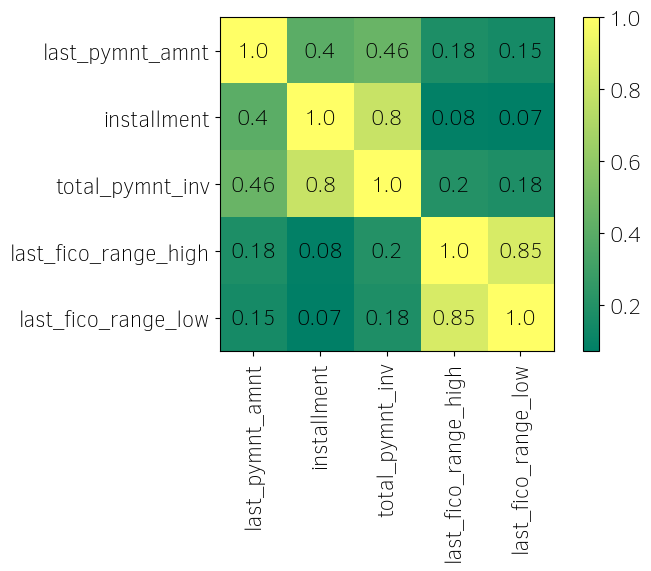

In [129]:
# correlation matrix
corr_matrix = np.corrcoef(X_train.values.T)
fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
im = ax.imshow(corr_matrix, cmap="summer")
ax.set_xticks(np.arange(len(X_train.columns)))
ax.set_yticks(np.arange(len(X_train.columns)))
ax.set_xticklabels(X_train.columns, rotation=90)
ax.set_yticklabels(X_train.columns)
for i in range(len(X_train.columns)):
    for j in range(len(X_train.columns)):
        text = ax.text(j, i, round(corr_matrix[i, j], 2), ha="center", va="center", color="black")
fig.colorbar(im)
plt.tight_layout()
plt.show()

In [75]:
# Univariate analysis
summary = {'Feature': [],
           'Gini': []}

univariate_scoring = RandomForestClassifier(n_estimators=5, random_state=42)

# loop over each variable, fit a logistic regression model and calculate the roc_auc_score
for feature in X_train.columns.unique():
    # select the column corresponding to the current variable

    # split the data into training and test sets
    X_tr, X_ts, y_tr, y_ts = train_test_split(X_train[feature].values.reshape(-1,1), 
                                              y.loc[ix_train].to_numpy().ravel(), 
                                              test_size=0.2, random_state=42)

    # fit a univariate scoring functions
    univariate_scoring.fit(X_tr, y_tr)
    
    # make predictions on the test set
    score = cross_val_score(univariate_scoring, X_ts, y_ts, cv=10).mean()
    
    summary['Feature'].append(feature)
    summary['Gini'].append(score*2-1)

print(pd.DataFrame(summary).sort_values(by='Gini', ascending=False))

                Feature      Gini
3  last_fico_range_high  0.723953
4   last_fico_range_low  0.721131
0       last_pymnt_amnt  0.583737
2       total_pymnt_inv  0.565248
1           installment  0.532311


In [76]:
# selecting features that go into the final model
internal_feats = ['last_pymnt_amnt', 'total_pymnt_inv']
print(f"Internal features: {internal_feats}")

external_feats = ['last_fico_range_high','last_fico_range_low']
print(f"External features: {external_feats}")

Internal features: ['last_pymnt_amnt', 'total_pymnt_inv']
External features: ['last_fico_range_high', 'last_fico_range_low']


In [77]:
# prepare train and test inputs
X_train = pd.concat([train_feats[internal_feats].loc[ix_train], 
                     train_feats[external_feats].loc[ix_train]], axis=1)

X_test = pd.concat([test_feats[internal_feats].loc[ix_test], 
                    test_feats[external_feats].loc[ix_test]], axis=1)

**Integrating models**

In [78]:
from classifiers import Classifiers

In [79]:
# Create dataframe mapper in preparation for sklearn modeling, which takes numeric numpy arrays
mapper = DataFrameMapper([
        ('last_pymnt_amnt', None),
        ('total_pymnt_inv', None),
        ('last_fico_range_high', None),
        ('last_fico_range_low', None),
])

print(f"Internal features: {internal_feats}\n"
      f"External features: {external_feats}")

Internal features: ['last_pymnt_amnt', 'total_pymnt_inv']
External features: ['last_fico_range_high', 'last_fico_range_low']


In [80]:
# specifying input features and models

clf_list = [('RF', internal_feats, RandomForestClassifier(n_estimators=100,
                                                          n_jobs=-1,
                                                          min_samples_leaf=5,
                                                          oob_score=False,
                                                          random_state=42)
            ), 
            ('LR', external_feats, LogisticRegression(solver='liblinear', 
                                                      max_iter=1000, 
                                                      random_state=42)
            )]

# Instantiate the Classifiers object
clf = Classifiers(clf_list, LogisticRegression(fit_intercept=True,
                                               solver='saga',
                                               l1_ratio=0,
                                               penalty='elasticnet'))

# Create the pipelines
clf.create_pipelines(mapper)

In [81]:
# Train the meta-model
meta_model = clf.train(X_train, y.loc[ix_train])

In [82]:
print(f"Models: {clf.classifier_names}\n"
#       f"Pipelines: {clf.pipelines}\n"
      f"Metamodel: {clf.meta_model}")

Models: ['RF', 'LR']
Metamodel: LogisticRegression(l1_ratio=0, penalty='elasticnet', solver='saga')


In [83]:
# predict
meta_preds = clf.predict_proba(meta_model, X_test)[:,1]
print(f"Gini - test: {roc_auc_score(y.loc[ix_test].to_numpy(), meta_preds)*2-1:.2%}")

Gini - test: 90.60%


#### <center> Individual models </center>

In [84]:
# This is standalone internal module
sk_rf_model = RandomForestClassifier(n_estimators=100,
                                     n_jobs=-1, min_samples_leaf=5,oob_score=False, random_state=42)
# training the model
sk_rf_model.fit(X_train[internal_feats].loc[ix_train], 
                y.loc[ix_train].values.ravel())

int_preds = sk_rf_model.predict_proba(X_test[internal_feats])[:,1]
print(f"Gini - test: {roc_auc_score(y.loc[ix_test].to_numpy(), int_preds)*2-1:.2%}")

Gini - test: 83.90%


In [85]:
# This is standalone external module
params = {"fit_intercept": True, 
          "penalty": "l2",
          "random_state": 72,
          "solver": "newton-cg",         
          }

# creating a pipeline
sk_lr_model = LogisticRegression(**params)

# training the model
sk_lr_model.fit(X_train[external_feats].loc[ix_train], 
    y.loc[ix_train].values.ravel())

ext_preds = sk_lr_model.predict_proba(X_test[external_feats].loc[ix_test])[:,1]
print(f"Gini - test: {roc_auc_score(y.loc[ix_test].to_numpy(), ext_preds)*2-1:.2%}")

Gini - test: 77.02%


#### <center> Challenger model </center>

In [43]:
import time
from xgboost import XGBClassifier

In [44]:
# A parameter grid for XGBoost
params = {
        'n_estimators': [10, 20, 50, 100, 200, 1000],
        'eta': [0.1, 0.3, 0.5]
        }

xgb = XGBClassifier(base_score=0.5,
                    objective='binary:logistic',
                    eval_metric='logloss',
                    nthread=1)

In [45]:
grid_search_xgb = GridSearchCV(
    xgb,
    params,
    n_jobs=1, 
    cv=5,
    verbose=-1)

start_time = time.time()

grid_search_xgb.fit(X_train, y.loc[ix_train])

print("--- %s seconds ---" % (time.time() - start_time))

print('\n All results:')
print(grid_search_xgb.cv_results_)

print(f"Best parameters: {grid_search_xgb.best_params_}")
print(f"Best score: {grid_search_xgb.best_score_*2-1:.2%}")

--- 161.15582609176636 seconds ---

 All results:
{'mean_fit_time': array([0.09631028, 0.18185911, 0.44591756, 0.83757329, 1.57077174,
       7.4515439 , 0.09225726, 0.17884812, 0.40501871, 0.77294731,
       1.51179256, 7.51377244, 0.09245954, 0.1719327 , 0.39365406,
       0.7718895 , 1.51672626, 7.50699639]), 'std_fit_time': array([0.00964793, 0.00212076, 0.0012487 , 0.00387816, 0.00818146,
       0.03425219, 0.00071367, 0.00115632, 0.00239771, 0.00495354,
       0.0099444 , 0.04090636, 0.00133963, 0.00190784, 0.00207535,
       0.00688484, 0.00917584, 0.03879597]), 'mean_score_time': array([0.00255985, 0.00361795, 0.00606766, 0.00960746, 0.01597304,
       0.06592302, 0.00258484, 0.00344129, 0.00540962, 0.00865631,
       0.01515126, 0.06608505, 0.00248938, 0.00323567, 0.00520287,
       0.00840955, 0.01493883, 0.06673369]), 'std_score_time': array([1.80574738e-04, 2.95154898e-04, 1.95600358e-04, 1.16233750e-04,
       2.03792994e-04, 3.90824921e-04, 4.78739757e-05, 1.34070753e-04,

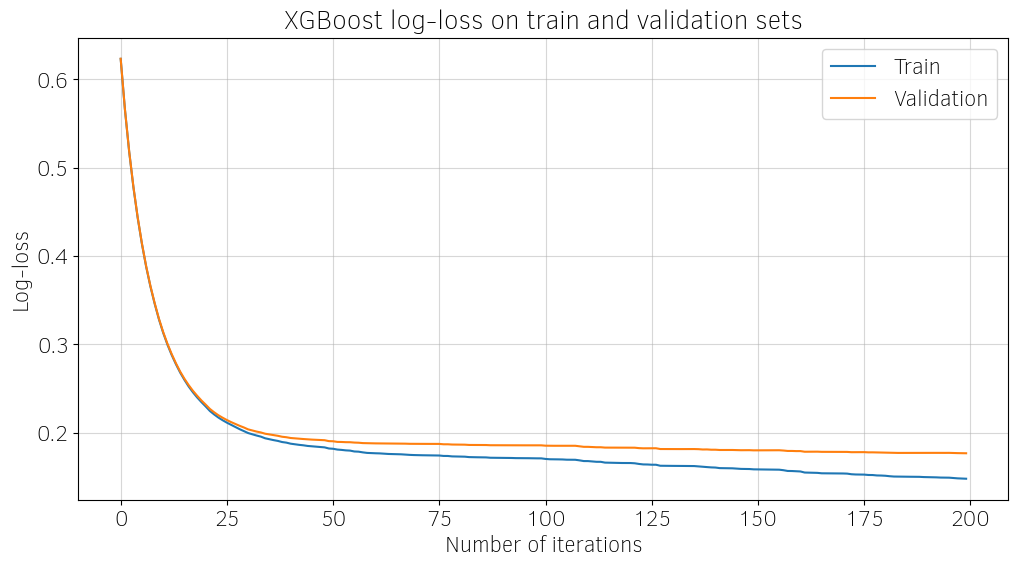

In [46]:
# fit the XGBoost model and track performance on train and validation sets
eval_set = [(X_train, y.loc[ix_train]), (X_test, y.loc[ix_test])]

model = XGBClassifier(**grid_search_xgb.best_params_)
model.fit(X_train, y.loc[ix_train], eval_set=eval_set, verbose=False)

# extract the training history
results = model.evals_result()
epochs = len(results['validation_0']['logloss'])

# plot the training and validation loss over time
plt.figure(figsize=(12,6))
plt.plot(range(0, epochs), results['validation_0']['logloss'], label='Train')
plt.plot(range(0, epochs), results['validation_1']['logloss'], label='Validation')
plt.legend(loc='upper right')
plt.grid(alpha=0.5)
plt.xlabel('Number of iterations')
plt.ylabel('Log-loss')
plt.title('XGBoost log-loss on train and validation sets')
plt.show()

In [47]:
xgb_preds = model.predict_proba(X_test)[:,1] # make inference on the test set

### <center> Profit </center>
|  Prediction       | Default +               | Default -          |
| --------- | ---------------------- | ------------------ |
| Predicted Default + | {0} Correctly Predict Default |{-avg_profit}	Falsely Predict Default |
| Predicted Default - | {-avg_loss} Falsely Predict Non-Default | {avg_profit} Correctly Predict Non-Default |

In [48]:
import utils as utils

In [130]:
# calculate rank-ordering
ext_gini = roc_auc_score(y.loc[ix_test].to_numpy(), ext_preds)*2-1
int_gini = roc_auc_score(y.loc[ix_test].to_numpy(), int_preds)*2-1
meta_gini = roc_auc_score(y.loc[ix_test].to_numpy(), meta_preds)*2-1
xgb_gini = roc_auc_score(y.loc[ix_test].to_numpy(), xgb_preds)*2-1

In [131]:
# Define cost-benefit matrix based on observed losses and profits
# [tp, fp], [fn, tn]: [Loss incurred, Profit lost, Loss incurred, Profit made]
costbenefit_mat = np.array([[0, -avg_profit],
                            [-avg_loss, avg_profit]])
print(costbenefit_mat)

[[    0.         -1430.12731632]
 [-1454.04754694  1430.12731632]]


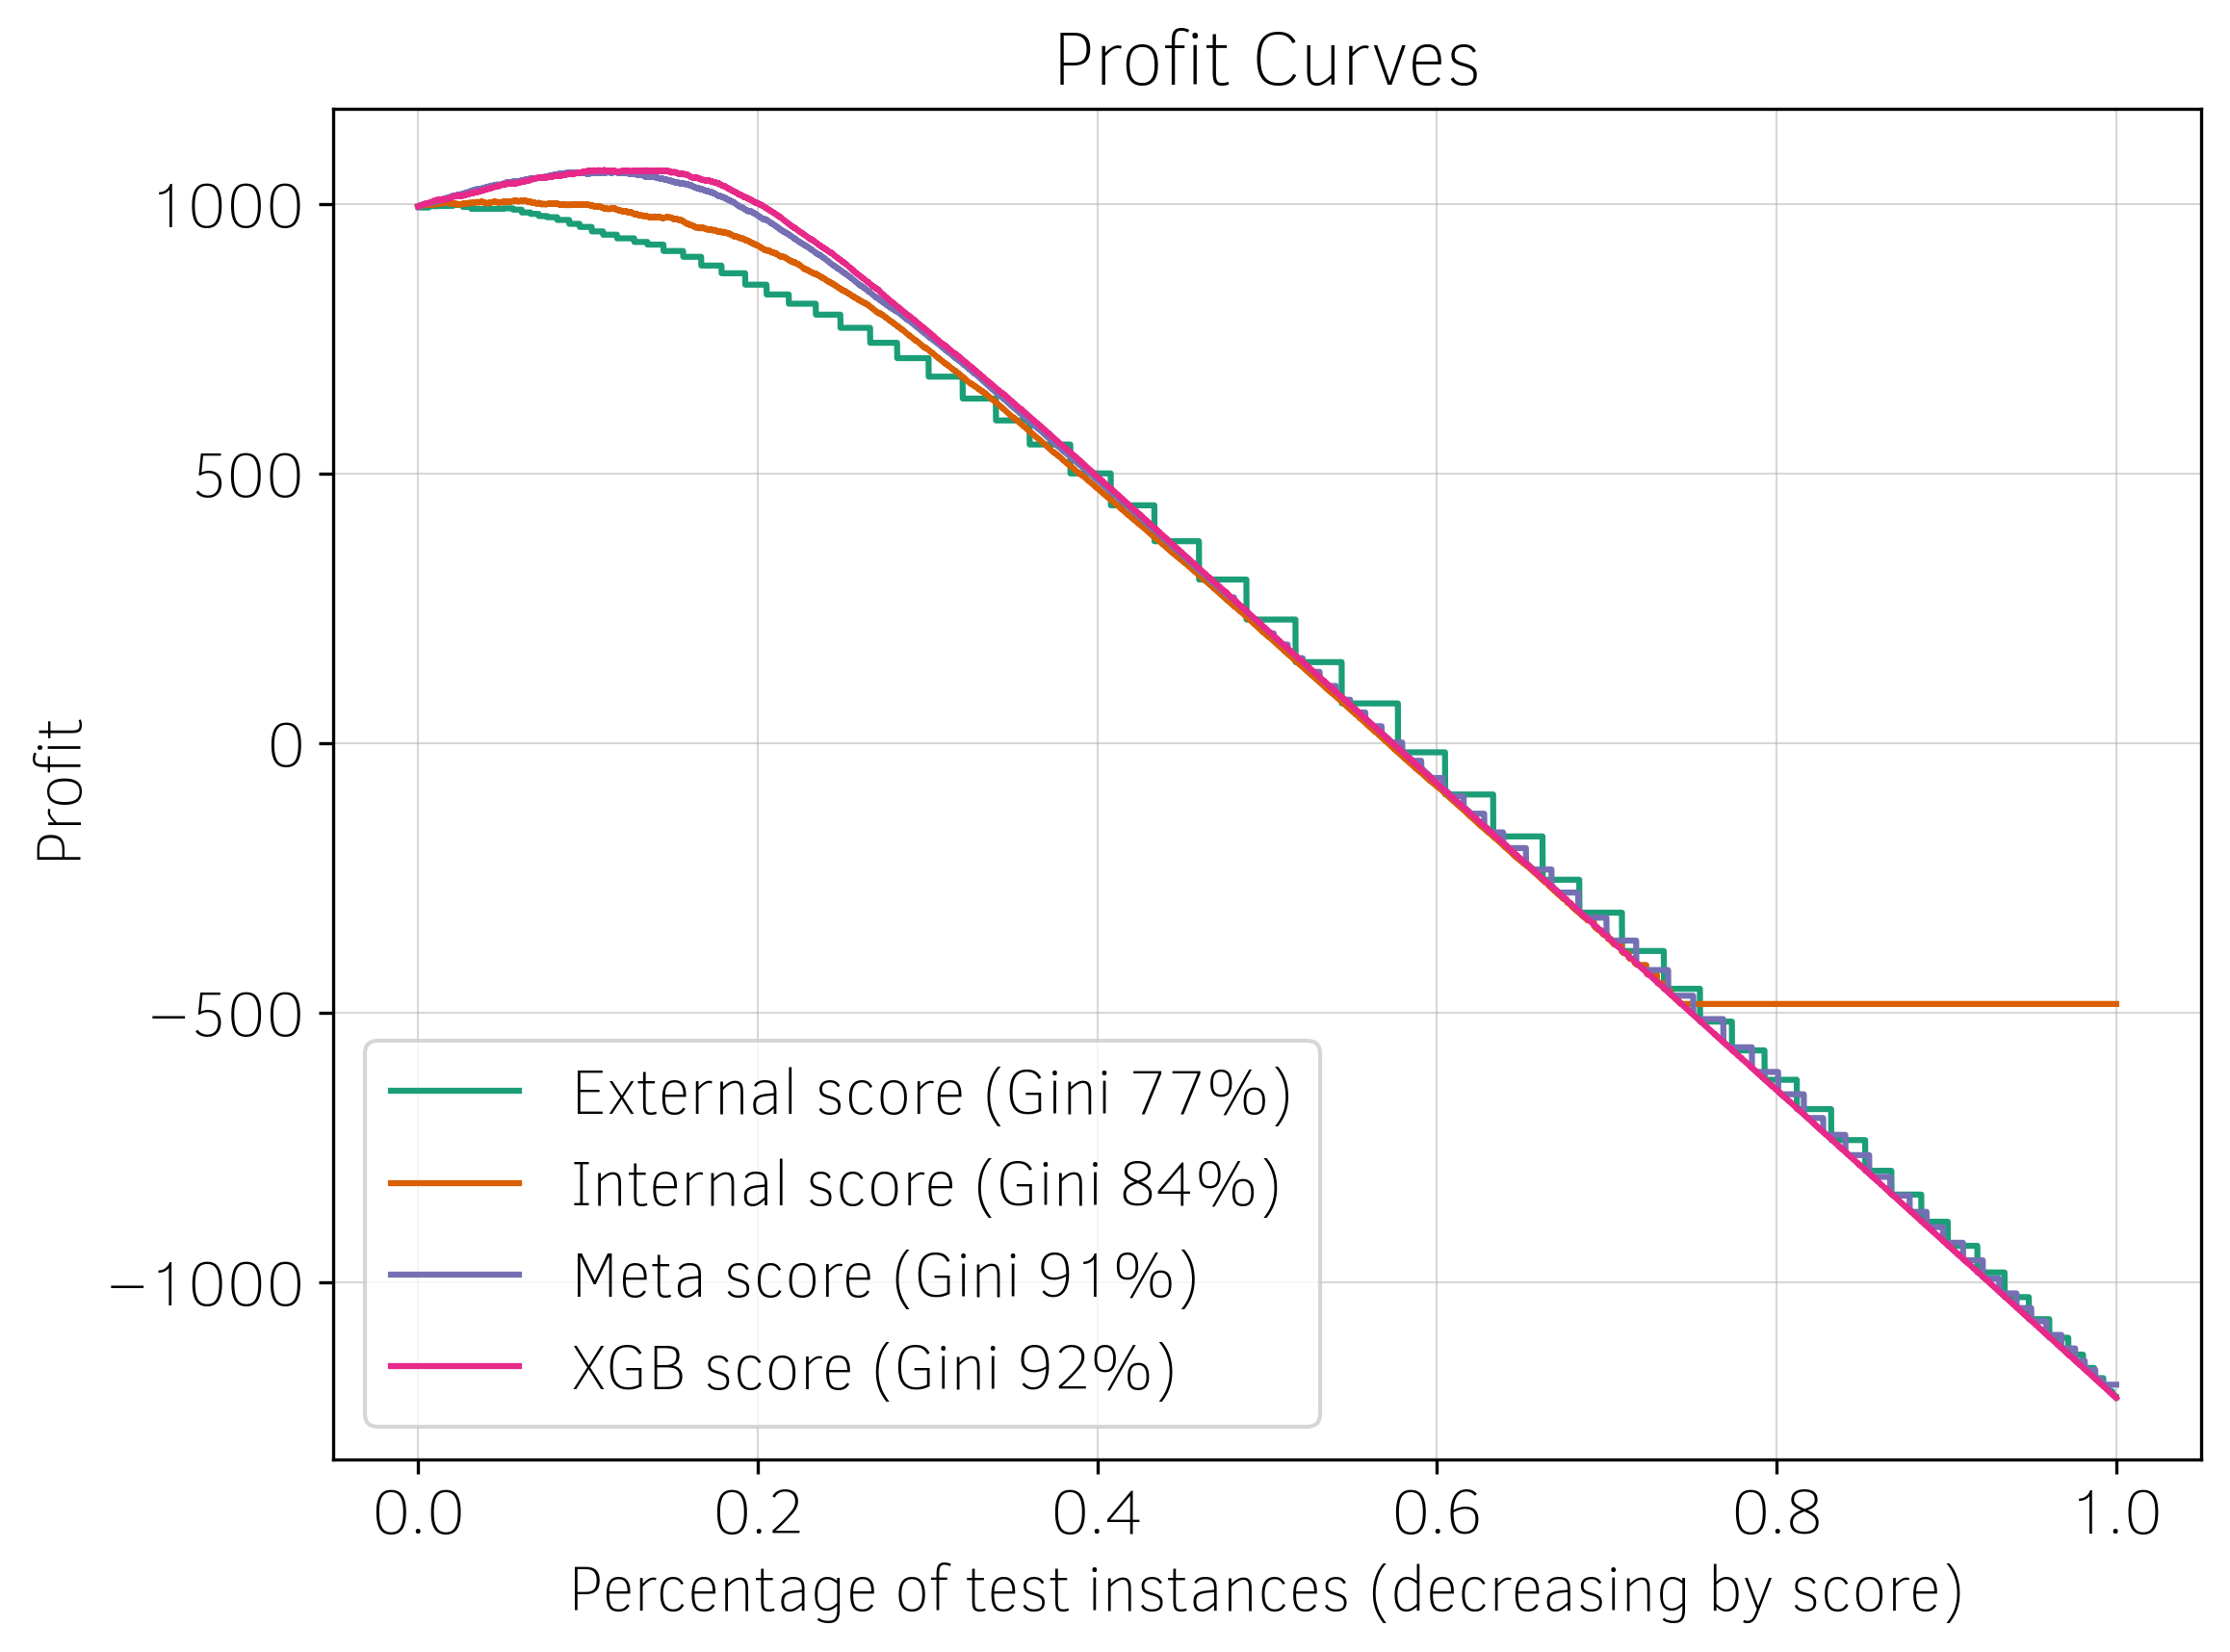

In [132]:
fig = plt.figure(figsize=(8, 6), dpi=300)
colors = plt.cm.Dark2

labels = [f"External score (Gini {ext_gini:.0%})",
          f"Internal score (Gini {int_gini:.0%})", 
          f"Meta score (Gini {meta_gini:.0%})", 
          f"XGB score (Gini {xgb_gini:.0%})"]

y_probas = [ext_preds, 
            int_preds,
            meta_preds,
            xgb_preds]

for i, y_proba in enumerate(y_probas):
    utils.plot_profit_curve(costbenefit_mat,
                            y_true=y.loc[ix_test].values, 
                            y_proba=y_proba,
                            color=colors(i),
                            label=labels[i],
                            linewidth=1.5)

plt.grid(True, alpha=0.5, which='both', axis='both', linewidth=0.5)
plt.xlabel('Percentage of test instances (decreasing by score)')
plt.ylabel('Profit')
plt.title('Profit Curves')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig('profit_curves.png', dpi=600)
plt.show()